In [1]:
%matplotlib inline
import intake
import xarray as xr
import matplotlib
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
import numpy as np
from esio import ice_plot
from esio import EsioData as ed
import dask

In [2]:
# File listing data in catalog
catalog_url = 'https://raw.githubusercontent.com/NicWayand/example.pangeo.io-deploy/staging/deployments/polar.pangeo.io/image/catalog.yaml'

In [3]:
# Get model info (load in existing pickel file with model details)
%env DATA_DIR=/home/jovyan/projects/esio/data
E = ed.EsioData.load()

env: DATA_DIR=/home/jovyan/projects/esio/data


In [4]:
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

### Click Above Link for Dask Visualization!!

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.28.1.47:40134 Dashboard: /user/nicwayand/proxy/46813/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load in Sea Ice Concentration (SIC) forecasts and observations
- SIP - Sea Ice Probability
- anomaly - Anomaly SIC from 1980-2010 observational average
- mean - Mean SIC for weekly period

In [6]:
ds_sic = intake.Catalog(catalog_url).SIPN2_SIC.to_dask()
ds_sic

<xarray.Dataset>
Dimensions:    (fore_time: 16, init_end: 42, model: 21, x: 304, y: 448)
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 0 days 7 days 14 days 21 days ...
  * init_end   (init_end) datetime64[ns] 2018-01-07 2018-01-14 2018-01-21 ...
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
  * model      (model) object 'Observed' 'awispin' 'climatology' ...
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y          (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    SIP        (init_end, model, fore_time, y, x) float64 dask.array<shape=(42, 21, 16, 448, 304), chunksize=(1, 1, 1, 448, 304)>
    anomaly    (init_end, model, fore_time, y, x) float64 dask.array<shape=(42, 21, 16, 448, 304), chunksize=(1, 1, 1, 448, 304)>
    mean       (init_end, model, fore_time, y, x) float64 dask.array<shape=(42

### This dataset contains 19 different models, plus Observations and the Multi-model Ensemble Mean (MME)

In [7]:
ds_sic.model

<xarray.DataArray 'model' (model: 21)>
array(['Observed', 'awispin', 'climatology', 'dampedAnomaly',
       'dampedAnomalyTrend', 'ecmwf', 'ecmwfsipn', 'gfdlsipn', 'kma',
       'metreofr', 'ncep', 'nicosipn', 'rasmesrl', 'szapirosipn',
       'ukmetofficesipn', 'ukmo', 'usnavygofs', 'usnavyncep', 'usnavysipn',
       'yopp', 'MME'], dtype=object)
Coordinates:
  * model    (model) object 'Observed' 'awispin' 'climatology' ...

### Forecast time ranges from 0 to 364 days

In [8]:
ds_sic.fore_time.values.astype('timedelta64[D]').astype(int)

array([  0,   7,  14,  21,  28,  61,  91, 122, 152, 183, 213, 243, 274,
       304, 335, 364])

### Initailization times are weekly, and init_end represents the END of the weekly period.

In [9]:
ds_sic.init_end

<xarray.DataArray 'init_end' (init_end: 42)>
array(['2018-01-07T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-28T00:00:00.000000000',
       '2018-02-04T00:00:00.000000000', '2018-02-11T00:00:00.000000000',
       '2018-02-18T00:00:00.000000000', '2018-02-25T00:00:00.000000000',
       '2018-03-04T00:00:00.000000000', '2018-03-11T00:00:00.000000000',
       '2018-03-18T00:00:00.000000000', '2018-03-25T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-04-08T00:00:00.000000000',
       '2018-04-15T00:00:00.000000000', '2018-04-22T00:00:00.000000000',
       '2018-04-29T00:00:00.000000000', '2018-05-06T00:00:00.000000000',
       '2018-05-13T00:00:00.000000000', '2018-05-20T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-06-03T00:00:00.000000000',
       '2018-06-10T00:00:00.000000000', '2018-06-17T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
      

### Plot the 1 month forecasted SIP from all models

In [10]:
fore_time_i = [4] # Fourth index is 28 days (add more here to get multiple plots)

In [11]:
init_end_v = np.datetime64('2018-08-05')

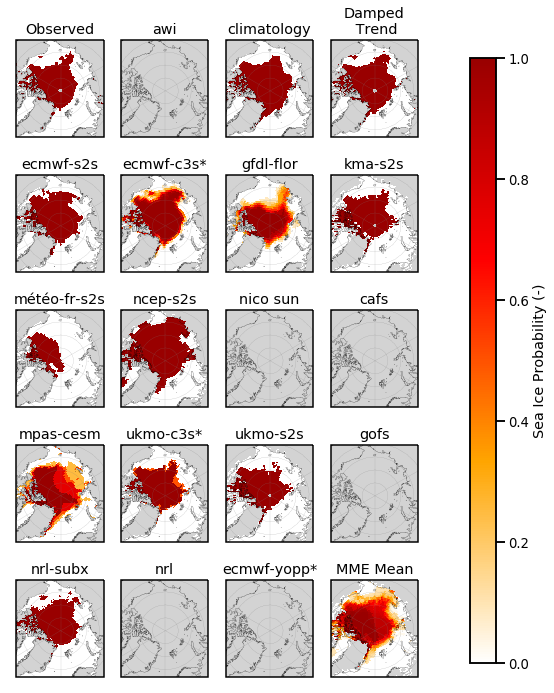

In [12]:
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# Set up color maps
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Probability (-)'
c_vmin = 0
c_vmax = 1

def add_subplot_title(cmod, E, ax=None):
    if cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)
        
# Drop dampedAnomaly because it damps to the 1980-2010 mean, not skillfull.
ds_sic = ds_sic.where(ds_sic.model!='dampedAnomaly', drop=True)

for ft in [ds_sic.fore_time.values[fore_time_i]]:  
    
    # Grab current lead time
    c_ft_ds = ds_sic.SIP.sel(fore_time=ft, init_end=init_end_v)
    
    # Drop models without any data
    #c_ft_ds = c_ft_ds.where(c_ft_ds.notnull().sum(dim=['x','y'])>0, drop=True)
    
    # Determine number of rows and columns
    nrows = np.int(np.ceil(np.sqrt(c_ft_ds.model.size)))
    ncols = int(np.ceil(c_ft_ds.model.size/nrows))
    Nplots = c_ft_ds.model.size + 1
    
    # New Plot
    central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45]
    (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
                                          extent=central_extent, central_longitude=0,
                                         sizefcter=1.2)

    for (i, cmod) in enumerate(c_ft_ds.model.values):
        if cmod in c_ft_ds.model.values:
            # Plot
            add_subplot_title(cmod, E, ax=axes[i])
            p = c_ft_ds.isel(fore_time=0).sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False,
                                  cmap=cmap_c,
                                  vmin=c_vmin, vmax=c_vmax)
            add_subplot_title(cmod, E, ax=axes[i])
    # Make pretty
    cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
    cbar.set_ticks(np.arange(0,1.1,0.2))

### Plot the Multi-model mean Sea Ice Concentration (SIC) forecast Initialized on 2018-08-05 with a lead time of 28 days

In [13]:
da = ds_sic['mean'].sel(model='MME').isel(init_end=30, fore_time=4)
da

<xarray.DataArray 'mean' (y: 448, x: 304)>
dask.array<shape=(448, 304), dtype=float64, chunksize=(448, 304)>
Coordinates:
    fore_time  timedelta64[ns] 28 days
    init_end   datetime64[ns] 2018-08-05
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    model      <U3 'MME'
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y          (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

Text(0.5,1,'Valid time\n2018-09-02')

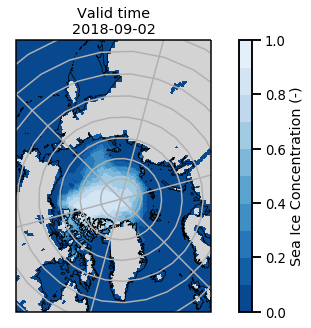

In [14]:
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')

(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)


da.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('Valid time\n'+pd.to_datetime((da.init_end+da.fore_time).values).strftime('%Y-%m-%d'))